In [ ]:
import pandas as pd
import numpy as np
import ast

from data_augmenter import duplicate_and_flip_actions, create_action_windows, augment_all_actions, explode_keypoints
from data_visualization import draw_random_frame, draw_random_window

PATH_KEYPOINTS_FILTERED             = "../Data/tmp/keypoints_filtered.csv"
PATH_METADATA                       = "../Data/Processed/metadata.csv"
PATH_DATA                           = "../Data/Processed/data.csv"

MINIMUM_DURATION                    = 4
WINDOWS_PER_ACTION                  = 5

JITTER_STD                          = 2.5
NOISE_STD                           = 2.5
SCALE_STD                           = 0.075
ROTATE_DEG                          = 7

In [24]:
df_keypoints = pd.read_csv(PATH_KEYPOINTS_FILTERED)

df_keypoints["box"] = df_keypoints["box"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

df_keypoints["keypoints"] = df_keypoints["keypoints"].apply(
    lambda x: [tuple(p) for p in ast.literal_eval(x)] if isinstance(x, str) else x
)

In [57]:
df_flipped = duplicate_and_flip_actions(
    df_keypoints, 
    image_width=1920
)

print(df_flipped)

print("Number of actions before flipping: ", df_keypoints["action_id"].nunique())
print("Number of actions after flipping:  ", df_flipped["action_id"].nunique())

               file fencer  action_id        action  frame  start_frame  \
0     1/10_Left.mp4   LEFT          0  ATTACK_LUNGE     23           23   
1     1/10_Left.mp4   LEFT          0  ATTACK_LUNGE     24           23   
2     1/10_Left.mp4   LEFT          0  ATTACK_LUNGE     25           23   
3     1/10_Left.mp4   LEFT          0  ATTACK_LUNGE     26           23   
4     1/10_Left.mp4  RIGHT          1  ATTACK_LUNGE     21           21   
...             ...    ...        ...           ...    ...          ...   
8479   6/9_Left.mp4   LEFT        948  ATTACK_LUNGE     23           20   
8480   6/9_Left.mp4   LEFT        948  ATTACK_LUNGE     24           20   
8481   6/9_Left.mp4   LEFT        948  ATTACK_LUNGE     25           20   
8482   6/9_Left.mp4   LEFT        948  ATTACK_LUNGE     26           20   
8483   6/9_Left.mp4   LEFT        948  ATTACK_LUNGE     27           20   

      end_frame                     box  confidence  \
0            26    (749, 585, 885, 791)    0

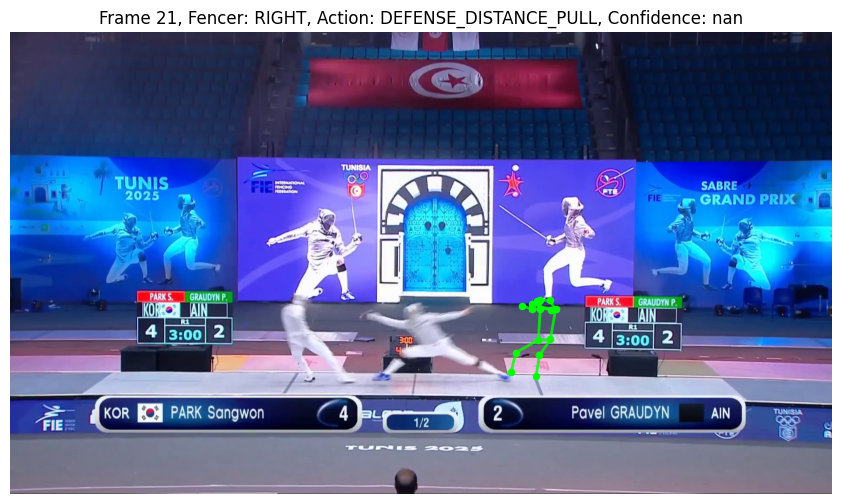

In [62]:
start_idx = len(df_keypoints)
df_flipped_only = df_flipped[df_flipped.index > start_idx]
draw_random_frame(df_flipped_only)

In [63]:
action_counts = df_flipped.groupby("action")["action_id"].nunique().sort_values(ascending=False)

print(action_counts)

action
ATTACK_LUNGE             340
DEFENSE_DISTANCE_PULL    130
ATTACK_STOP_CUT          100
ATTACK_STEP_CUT           80
ATTACK_BEAT               64
DEFENSE_POINT_IN_LINE     62
ATTACK_COUNTER            52
ATTACK_RIPOSTE            26
ATTACK_FLUNGE             20
ATTACK_FEINT              18
DEFENSE_PARRY_4           18
DEFENSE_PARRY_5           14
ATTACK_REMISE             12
DEFENSE_PARRY_2           12
Name: action_id, dtype: int64


In [64]:
max_count = action_counts.max()
class_weights = max_count / action_counts
weights_dict = class_weights.to_dict()

print(class_weights)

action
ATTACK_LUNGE              1.000000
DEFENSE_DISTANCE_PULL     2.615385
ATTACK_STOP_CUT           3.400000
ATTACK_STEP_CUT           4.250000
ATTACK_BEAT               5.312500
DEFENSE_POINT_IN_LINE     5.483871
ATTACK_COUNTER            6.538462
ATTACK_RIPOSTE           13.076923
ATTACK_FLUNGE            17.000000
ATTACK_FEINT             18.888889
DEFENSE_PARRY_4          18.888889
DEFENSE_PARRY_5          24.285714
ATTACK_REMISE            28.333333
DEFENSE_PARRY_2          28.333333
Name: action_id, dtype: float64


In [65]:
df_windowed = create_action_windows(
    df_flipped, 
    window_size=MINIMUM_DURATION, 
    base_windows=WINDOWS_PER_ACTION,
    class_weights=weights_dict, 
    random_state=42
)

new_action_counts = df_windowed.groupby("action")["window_id"].nunique().sort_values(ascending=False)
print(new_action_counts)
print("")
print("Number of action snippets: ", df_windowed["window_id"].nunique())

action
ATTACK_BEAT              1728
ATTACK_COUNTER           1716
ATTACK_REMISE            1704
DEFENSE_PARRY_2          1704
ATTACK_LUNGE             1700
ATTACK_FLUNGE            1700
ATTACK_STOP_CUT          1700
DEFENSE_PARRY_5          1694
ATTACK_FEINT             1692
DEFENSE_PARRY_4          1692
ATTACK_RIPOSTE           1690
DEFENSE_DISTANCE_PULL    1690
ATTACK_STEP_CUT          1680
DEFENSE_POINT_IN_LINE    1674
Name: window_id, dtype: int64

Number of action snippets:  23764


In [67]:
df_augmented = augment_all_actions(df_windowed,
    jitter_std=JITTER_STD,
    noise_std=NOISE_STD,
    scale_std=SCALE_STD,
    rotate_deg=ROTATE_DEG
)

df_augmented = df_augmented[
    ["file", "fencer", "action_id", "window_id", "action", "frame", "start_frame", "end_frame", "box", "confidence", "keypoints"]
].sort_values(["file", "action_id", "window_id", "frame"]).reset_index(drop=True)

print(df_augmented)
print("")

                file fencer  action_id  window_id        action  frame  \
0      1/10_Left.mp4   LEFT          0          1  ATTACK_LUNGE     23   
1      1/10_Left.mp4   LEFT          0          1  ATTACK_LUNGE     24   
2      1/10_Left.mp4   LEFT          0          1  ATTACK_LUNGE     25   
3      1/10_Left.mp4   LEFT          0          1  ATTACK_LUNGE     26   
4      1/10_Left.mp4   LEFT          0          2  ATTACK_LUNGE     23   
...              ...    ...        ...        ...           ...    ...   
95051   6/9_Left.mp4   LEFT        948      23763  ATTACK_LUNGE     26   
95052   6/9_Left.mp4   LEFT        948      23764  ATTACK_LUNGE     21   
95053   6/9_Left.mp4   LEFT        948      23764  ATTACK_LUNGE     22   
95054   6/9_Left.mp4   LEFT        948      23764  ATTACK_LUNGE     23   
95055   6/9_Left.mp4   LEFT        948      23764  ATTACK_LUNGE     24   

       start_frame  end_frame                   box  confidence  \
0               23         26  (749, 585, 88

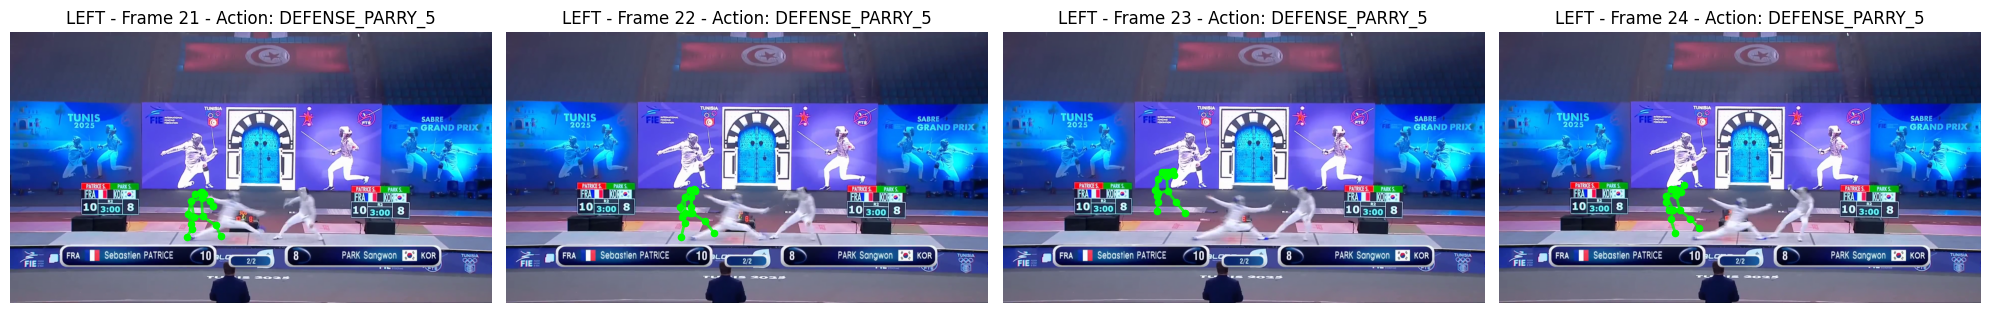

In [75]:
draw_random_window(df_augmented)

In [76]:
df_metadata = df_augmented[["file", "fencer", "action_id", "window_id", "action", "frame", "start_frame", "end_frame", "box", "confidence"]]
df_metadata.to_csv(PATH_METADATA, index=False)

df_data = df_augmented[["window_id", "frame", "action", "keypoints"]]
df_data.sort_values(["window_id"], inplace=True)

df_data = explode_keypoints(df_data)
df_data.to_csv(PATH_DATA, index=False)

/tmp/ipykernel_60270/3189362707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.sort_values(["window_id"], inplace=True)
